In [1]:
import sys
sys.path.append('..')

from data.tile_stitcher import stitch_predictions


In [2]:
ckpt = '2502/HT_LIF24-joint_indi-l1/60'
# ckpt = '2502/BioSR-joint_indi-l1/5'
# ckpt = '2502/Hagen-joint_indi-l1/63'
training_rootdir = '/group/GROUPNAMEUSERNAME/training/diffsplit/'
num_steps_normalization = 10_000
ckpt_time_predictor = None #'2502/BioSR-UnetClassifier-l2/4/'
time_predictor = None
mmse_count = 10

num_timesteps = 1
enable_real_input = False
infer_time = False
use_aggregated_inferred_time = False
use_hardcoded_time_for_inference = None


ckpt = ckpt.strip('/').strip(' ')
ckpt

'2502/HT_LIF24-joint_indi-l1/60'

In [3]:
if use_aggregated_inferred_time:
    assert ckpt_time_predictor is not None, 'Time predictor is required for aggregated time inference'
    assert use_hardcoded_time_for_inference is use_hardcoded_time_for_inference, 'Hardcoded time inference is not supported with aggregated time inference'
    assert infer_time is True, 'Time inference must be enabled for aggregated time inference'


if infer_time:
    assert ckpt_time_predictor is not None, 'Time predictor is required for time inference'

if use_hardcoded_time_for_inference is not None:
    assert not infer_time, 'Time inference must be disabled for hardcoded time inference'

# assert mixing_t_ood >= 0 and mixing_t_ood <= 1, 'mixing_t_ood must be in [0, 1]'
assert enable_real_input is False, 'Real input is not supported in this notebook.'

In [4]:
import yaml
import os
import glob

def model_checkpoint_fpath(fname=None):
    ckpt_dir = os.path.join(training_rootdir, ckpt, 'checkpoint')
    if fname is not None:
        return os.path.join(training_rootdir, ckpt, fname)
    else:
        list_of_files = glob.glob(ckpt_dir +'/*_gen.pth') # * means all if need specific format then *.csv
        latest_file = max(list_of_files, key=os.path.getctime)
        # best_files = [f for f in list_of_files if 'best_gen_' in f]
        # assert len(best_files) == 1,f'{best_files}'
        # best_file = best_files[0]  
        fname = latest_file
        return os.path.join(ckpt_dir,fname)

def model_checkpoint_fpath_prefix(fname=None):
    fpath = model_checkpoint_fpath(fname)
    suffix = '_gen.pth'
    assert fpath.endswith(suffix)
    return fpath[:-len(suffix)]

def load_config(ckpt):
    config_path = os.path.join(training_rootdir,ckpt,'wandb/latest-run/files/config.yaml')

    with open(config_path) as stream:
        
        try:
            opt = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)
    
    keys = ["name","phase","gpu_ids","path","datasets","model","train", "distributed"]
    output = {}
    for k in keys:
        if k in opt:
            output[k] = opt[k]['value']
    return output

In [5]:
from model.ddpm_modules.time_predictor import TimePredictor
from time_prediction_training import get_datasets
import os
import torch

if ckpt_time_predictor is not None:
    time_pred_ckpt_fpath = os.path.join(training_rootdir, ckpt_time_predictor)

    time_pred_opt = load_config(time_pred_ckpt_fpath)
    time_pred_model_opt = time_pred_opt['model']
    time_predictor = TimePredictor(
        in_channel=time_pred_model_opt['unet']['in_channel'],
        out_channel=time_pred_model_opt['unet']['out_channel'],
        norm_groups=time_pred_model_opt['unet']['norm_groups'],
        inner_channel=time_pred_model_opt['unet']['inner_channel'],
        channel_mults=time_pred_model_opt['unet']['channel_multiplier'],
        attn_res=time_pred_model_opt['unet']['attn_res'],
        res_blocks=time_pred_model_opt['unet']['res_blocks'],
        dropout=time_pred_model_opt['unet']['dropout'],
        image_size=time_pred_opt['datasets']['patch_size'],
        )
    
    time_predictor = time_predictor.cuda()
    time_predictor.load_state_dict(torch.load(os.path.join(time_pred_ckpt_fpath,'best_time_predictor.pth')), strict=True)
    time_predictor.eval()
    print('Loaded time predictor from', time_pred_ckpt_fpath)


/localscratch/miniforge3/envs/usplit_vdi/lib/python3.9/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [6]:
opt = load_config(ckpt)
opt['path']['resume_state'] = model_checkpoint_fpath_prefix()
# opt['path']['resume_state'] = os.path.join(os.path.dirname(opt['path']['resume_state']),'I110000_E1375')
print(opt['path']['resume_state'])

opt['model']['beta_schedule']['val']['n_timestep'] = num_timesteps
if opt['datasets']['train']['name'] == 'COSEM_jrc-hela':
    opt['datasets']['val']['datapath'] = opt['datasets']['val']['datapath'].replace('val_jrc_hela','test_jrc_hela')

elif opt['datasets']['train']['name'].lower() == 'hagen':
    opt['datasets']['val']['datapath'] = {
    'ch0': '/group/GROUPNAMEUSERNAME/data/diffsplit_hagen/test/test_actin-60x-noise2-highsnr.tif',
    'ch1': '/group/GROUPNAMEUSERNAME/data/diffsplit_hagen/test/test_mito-60x-noise2-highsnr.tif'
    }
elif opt['datasets']['train']['name'] in ['HT_LIF24','HT_LIF', 'BioSR', 'HT_T24']:
    opt['datasets']['val']['datapath'] = opt['datasets']['val']['datapath'].replace('/val','/test')
else:
    raise NotImplementedError(f'Unknown dataset {opt["datasets"]["train"]["name"]}')


/group/GROUPNAMEUSERNAME/training/diffsplit/2502/HT_LIF24-joint_indi-l1/60/checkpoint/I450000_E4412


In [7]:
if 'patch_size' not in opt['datasets']:
    opt['datasets']['patch_size']  = opt['datasets']['train']['patch_size']

if 'uncorrelated_channels' not in opt['datasets']['train']:
    opt['datasets']['train']['uncorrelated_channels']  = False

if enable_real_input:
    opt['datasets']['train']['real_input_fraction'] = 1.0
    opt['datasets']['val']['real_input_fraction'] = 1.0

opt['datasets']['normalize_channels'] = False

In [8]:
import torch
import data as Data
import model as Model
from data.split_dataset import SplitDataset, DataLocation
from split import get_datasets
import os


# data
train_set, val_set = get_datasets(opt, tiled_pred=False)

Loading data from /group/GROUPNAMEUSERNAME/data/diffsplit_HT_LIF/500ms/Ch_B-Ch_D-Ch_BD/train/train_500ms_Ch_B-Ch_D-Ch_BD.tif
Using first 0/90 for real input
Computing mean and std for normalization
[SplitDataset] Data: 90x3x(1608, 1608) Patch:512 Random:1 Aug:True Q:1.0 UpperClip:0Uncor:False RealFraction:0.0 InpFrmNormTar
Loading data from /group/GROUPNAMEUSERNAME/data/diffsplit_HT_LIF/500ms/Ch_B-Ch_D-Ch_BD/test/test_500ms_Ch_B-Ch_D-Ch_BD.tif
[SplitDataset] Data: 10x3x(1608, 1608) Patch:512 Random:0 Aug:False Q:1.0 UpperClip:0Uncor:False InpFrmNormTar


In [9]:
from split import get_xt_normalizer
val_set.set_random_patching(True)
xt_normalizer1, xt_normalizer2 = get_xt_normalizer(val_set,opt['datasets']['train'], num_bins=100, 
                                                   num_steps=num_steps_normalization)
val_set.set_random_patching(False)

Random patching set to True


10054 patches processed:   0%|          | 0/2 [00:00<?, ?it/s]

Random patching set to False


True

# Compute the normalization statistics with normalizer.

In [15]:
# ignore the normalization for the input channels
val_set.normalization_dict['mean_channel'] = val_set.normalization_dict['mean_channel'][:2]
val_set.normalization_dict['std_channel'] = val_set.normalization_dict['std_channel'][:2]

In [16]:
import numpy as np
from tqdm import tqdm
mixing_t_arr = np.arange(0,1.0, 0.1)
from collections import defaultdict

mean_list_ours = defaultdict(list)
std_list_ours = defaultdict(list)
mean_list_inDI = defaultdict(list)
std_list_inDI = defaultdict(list)

idx_list = np.random.RandomState(955).randint(0,len(val_set),size=2000)
for mixing_t in tqdm(mixing_t_arr):
    mixing_t = round(mixing_t,2)
    for idx in idx_list:
        tar = val_set[idx]['target']
        inp = tar[0] * (1-mixing_t) + tar[1] * mixing_t
        inp = torch.Tensor(inp[None,None]).cuda()
        inp = xt_normalizer1.normalize(inp, torch.Tensor([mixing_t]).cuda())
        mean_list_ours[mixing_t].append(inp.mean().item())
        std_list_ours[mixing_t].append(inp.std().item())

        tar_normalized = val_set.normalize_channels(tar)
        inp = tar_normalized[0] * (1-mixing_t) + tar_normalized[1] * mixing_t

        mean_list_inDI[mixing_t].append(inp.mean())
        std_list_inDI[mixing_t].append(inp.std())


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [01:04<00:00,  6.48s/it]


In [17]:
import pandas as pd
our_mean_df = pd.DataFrame.from_dict(mean_list_ours)
our_std_df = pd.DataFrame.from_dict(std_list_ours)
indi_mean_df = pd.DataFrame.from_dict(mean_list_inDI)
indi_std_df = pd.DataFrame.from_dict(std_list_inDI)

In [18]:
# outputdir = '/group/GROUPNAMEUSERNAME/indiSplitResults/'

# _,ax = plt.subplots(figsize=(2,2),ncols=1,nrows=1)
# ax[0].plot(indi_mean_df.mean(axis=0), label='inDI', marker='o')
# ax[0].plot(our_mean_df.mean(axis=0), label='indiSplit', marker='o')

# ax[1].plot(indi_std_df.mean(axis=0), label='inDI-std', marker='o')
# ax[1].plot(our_std_df.mean(axis=0), label='indiSplit-std', marker='o')
# ax[0].legend(loc='lower right', fancybox=True, framealpha=0.5)
# # ax[1].legend(loc = 'lower left',fancybox=True, framealpha=0.5)
# ax[0].grid()
# ax[1].grid()
# ax[0].set_title('Mean')
# ax[1].set_title('Std')
# ax[0].set_xlabel('$w$')
# ax[1].set_xlabel('$w$')

# # set face color
# for a in ax:
#     a.set_facecolor('lightgray')
#     # a.set_xlabel('Mixing ratio')
#     # a.set_ylabel('Mean')
# dset = opt['datasets']['train']['name'].lower()
# fpath = f"{outputdir}/normalization_comparison_{dset}.png"
# plt.tight_layout()
# plt.savefig(fpath, dpi=250,bbox_inches='tight')
# print(fpath)

/group/GROUPNAMEUSERNAME/indiSplitResults//normalization_comparison_ht_lif24.png


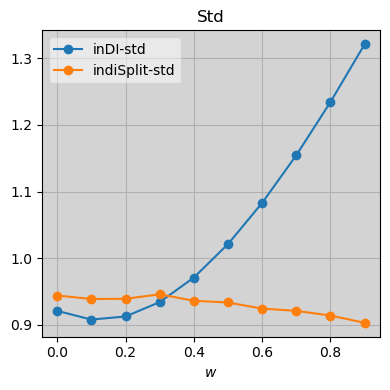

In [20]:
import matplotlib.pyplot as plt

outputdir = '/group/GROUPNAMEUSERNAME/indiSplitResults/'

_,ax = plt.subplots(figsize=(4,4),ncols=1,nrows=1)
# ax.plot(indi_mean_df.mean(axis=0), label='inDI', marker='o')
# ax[0].plot(our_mean_df.mean(axis=0), label='indiSplit', marker='o')

ax.plot(indi_std_df.mean(axis=0), label='inDI-std', marker='o')
ax.plot(our_std_df.mean(axis=0), label='indiSplit-std', marker='o')
ax.legend(loc='upper left', fancybox=True, framealpha=0.5)
# ax[1].legend(loc = 'lower left',fancybox=True, framealpha=0.5)
ax.grid()
ax.set_title('Std')
ax.set_xlabel('$w$')

# set face color
ax.set_facecolor('lightgray')
dset = opt['datasets']['train']['name'].lower()
fpath = f"{outputdir}/normalization_comparison_{dset}.png"
plt.tight_layout()
plt.savefig(fpath, dpi=250,bbox_inches='tight')
print(fpath)